C:\Users\user\Desktop\AMHCD_64\AMHCD_64
C:\Users\user\Deep learning
labels-map.csv not found. Please check the dataset structure.
Loaded 25740 samples with 33 unique classes.
Train: 15444 samples, Validation: 5148 samples, Test: 5148 samples
Epoch 0, Train Loss: 3.5039, Val Loss: 3.4965, Train Acc: 0.0306, Val Acc: 0.0319
Epoch 10, Train Loss: 3.5032, Val Loss: 3.4957, Train Acc: 0.0588, Val Acc: 0.0571
Epoch 20, Train Loss: 2.9024, Val Loss: 2.8856, Train Acc: 0.0803, Val Acc: 0.0859
Epoch 30, Train Loss: 2.0357, Val Loss: 2.0603, Train Acc: 0.3159, Val Acc: 0.3147
Epoch 40, Train Loss: 1.2189, Val Loss: 1.3122, Train Acc: 0.5598, Val Acc: 0.5602
Epoch 50, Train Loss: 0.7948, Val Loss: 1.0232, Train Acc: 0.6930, Val Acc: 0.6871
Epoch 60, Train Loss: 0.5874, Val Loss: 0.5901, Train Acc: 0.8415, Val Acc: 0.8263
Epoch 70, Train Loss: 0.4746, Val Loss: 0.7080, Train Acc: 0.7945, Val Acc: 0.7791
Epoch 80, Train Loss: 0.4065, Val Loss: 0.4451, Train Acc: 0.8979, Val Acc: 0.8763
Epoch 90, Tr

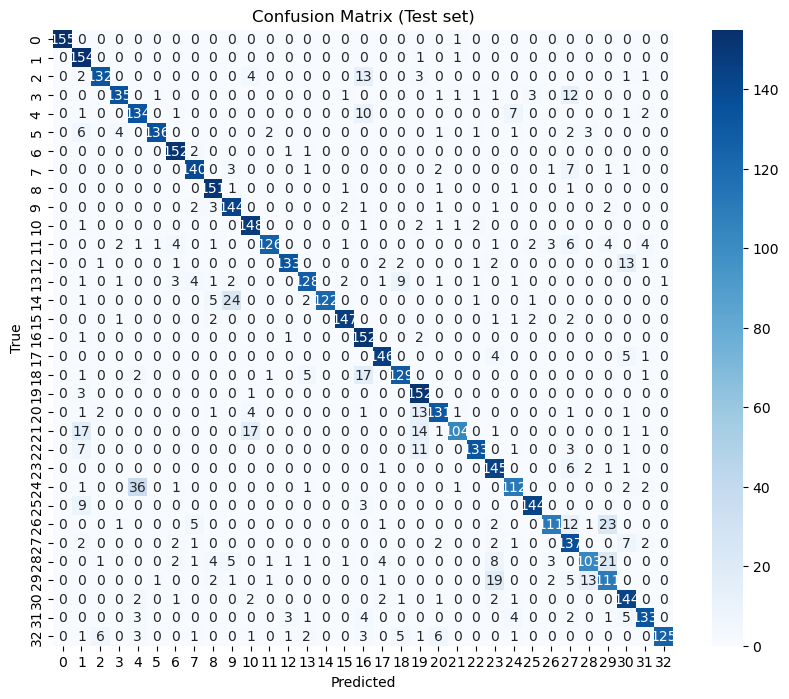

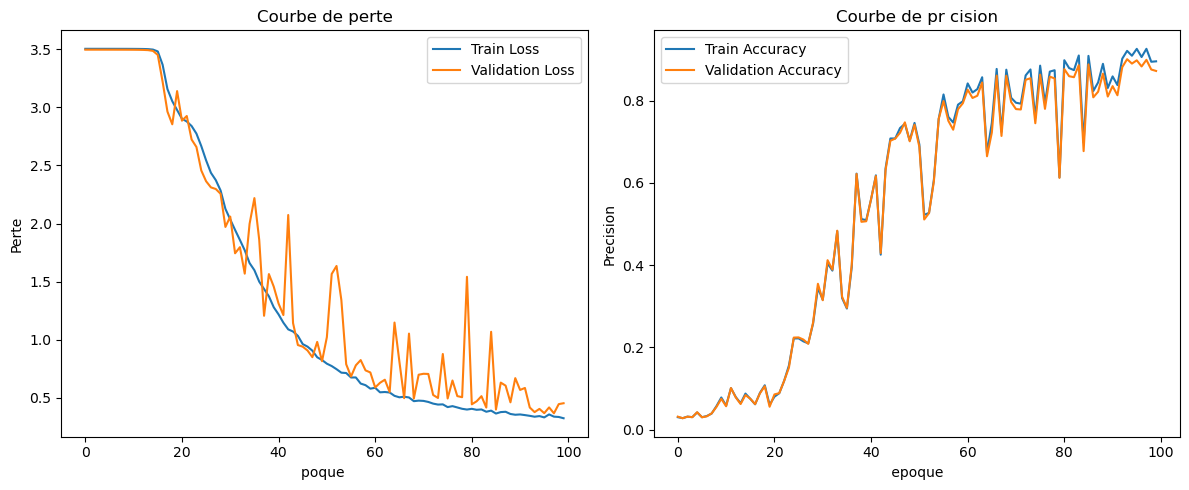

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Activation functions
def relu(x):
    """ReLU activation: max(0, x)"""
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for stability
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

# Neural network class
class MulticlassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

         # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1])
            assert b.shape ==  (1, layer_sizes[i+1])
            self.weights.append(w)
            self.biases.append(b)

        
         
    # Forward Propagation
    def forward(self, X):
        
        
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({ self.layer_sizes[0]})"
        assert isinstance(X, np.ndarray), "Input X must be a numpyarray"
        self.z_values = []
        self.activations = [X]

 
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        
        return self.activations[-1]

    # loss
    def compute_loss(self, y_true, y_pred):
        
        m = y_true.shape[0]
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        y_pred = np.clip(y_pred, 1e-15, 1- 1e-15)
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        loss = -np.sum(y_true * np.log(y_pred )) / m   
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):

        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]   
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        
        dZ = outputs - y  # Gradient for softmax + cross-entropy
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i+1].T) * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i+1]), f"dZ^{[i+1]} has incorrect shape"
            self.d_weights[i] = 1/m * np.dot(self.activations[i].T , dZ)      
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            
           # Ajout de la régularisation L2
            lambda_reg = 0.01  # Coefficient de régularisation
            self.d_weights[i] += (lambda_reg / m) * self.weights[i]
            
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        
        assert isinstance(X, np.ndarray), "Input X must be a numpyarray"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions



 
# Load and preprocess data
data_dir = os.path.join(os.getcwd(), r"C:\Users\user\Desktop\AMHCD_64\AMHCD_64")
print(data_dir)
current_working_directory = os.getcwd()
print(current_working_directory)

 
try:
    labels_df = pd.read_csv(os.path.join(data_dir, 'labels-map.csv'))
    assert "image_path" in labels_df.columns and "label" in labels_df.columns, "CSV must contain 'image_path' and 'label' columns "
    
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
     # Alternative : construire un DataFrame
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path,img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label':labels})



# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

# Charger toutes les images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Diviser en ensembles d’entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

 
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0],  "Train-val-test split sizes must sum to total samples"

print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Encoder les étiquettes en one-hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

# Vérifier que les tableaux one-hot sont des NumPy arrays
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"

# Créer et entraîner le modèle
input_size = 32 * 32 * 3
layer_sizes = [input_size, 64, 32, num_classes]

nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=0.01)

train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100, batch_size=32
)

 # Pr dictions et valuation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

            
# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



 # Courbe de perte
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel('poque ')
ax1.set_ylabel('Perte')
ax1.legend()
                                              
# Courbe d’accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de pr cision')
ax2.set_xlabel(' epoque ')
ax2.set_ylabel('Precision')
ax2.legend()
                                              
plt.tight_layout()
plt.show()
 



